# # Aplicación de arquitectura LSTM para muestra 176s
El problema ahora se encarará empleando redes neuronales de tipo _Long Short-Term Memory_ (LSTM). 

## Librerías necesarias

In [2]:
# Librerías principales
import os
import numpy as np
import pandas as pd

# Herramientas para graficar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Grid
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy import signal

from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.models import Model
from keras.layers import Input


# Versiones de librerías
print("".join(f"{x[0]}: {x[1]}\n" for x in [
    ("Numpy",np.__version__),
    ("Pandas",pd.__version__),
]))


Numpy: 1.21.6
Pandas: 1.3.5



## Carga del dataset
Se carga un dataset a la vez, como primer prueba

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/tsa/data'
files_name = 'dataset_176s.csv'

In [5]:
df = pd.read_csv(os.path.join(path, files_name), index_col='Time')
df.describe()

,Bearing 1
count,3001.000000
mean,0.008645
std,0.633791
min,-5.000000
25%,-0.273000
50%,-0.005000
75%,0.286000
max,4.998000


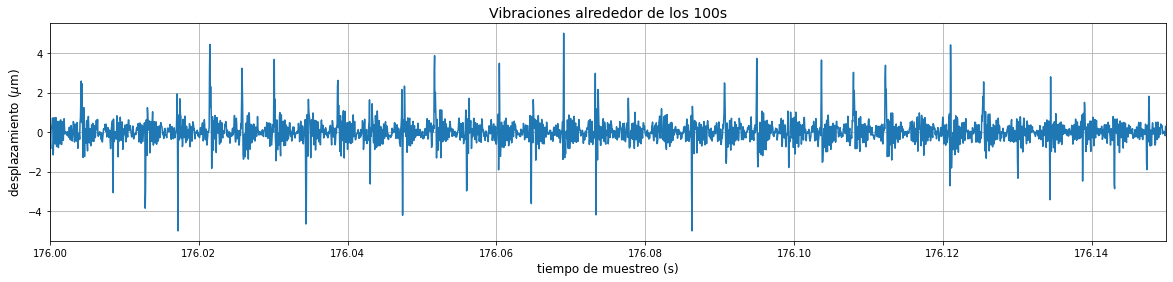

In [6]:
plt.figure(figsize=(20,4))

plt.plot(df.index, df)
plt.xlim(df.index[0], df.index[-1])
plt.grid()
plt.xlabel('tiempo de muestreo (s)', fontsize=12)
plt.ylabel('desplazamiento ($\mu$m)', fontsize=12)
plt.title(f'Vibraciones alrededor de los 100s', fontsize=14)

plt.show()

## Preprocesamiento


In [7]:
tokens = df['Bearing 1'].tolist()
tokens[:10]

[-0.425, -0.564, -0.84, 0.1, 0.212, 0.264, 0.447, 0.713, -0.081, -1.152]

In [8]:
time = df.index.tolist()
time[:10]

[176.0,
 176.00005,
 176.0001,
 176.00015,
 176.0002,
 176.00024,
 176.0003,
 176.00035,
 176.0004,
 176.00044]

In [9]:
# Código para hacer el desfazaje de los tokens
# según el train_len
train_len = 9

sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  sequences.append(seq)

In [10]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
# sequences[:5]

In [11]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 2992


## Input y Target

In [12]:
arr_sequences = np.array(sequences)
X = arr_sequences[:,:-1]
y = arr_sequences[:,-1]

print("Dimensiones input:", X.shape)
print("Dimensiones target:", y.shape)

Dimensiones input: (2992, 8)
Dimensiones target: (2992,)


## Preparación 


In [13]:
# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
# Cada dato lo transformarmos en una matriz de 1 fila 1 columna (1x1)
X_train = np.array(X_train).reshape(len(X_train), len(X_train[0]), 1)
X_test = np.array(X_test).reshape(len(X_test), len(X_test[0]), 1)
print("Dimensiones X_train:", X_train.shape)
print("Dimensiones X_test:", X_test.shape)

Dimensiones X_train: (2393, 8, 1)
Dimensiones X_test: (599, 8, 1)


## Modelo

In [15]:
input_shape = X_train[0].shape
input_shape

(8, 1)

In [16]:
output_shape = 1
output_shape

1

In [17]:
model = Sequential()
model.add(LSTM(64, activation='sigmoid', return_sequences=True, input_shape=input_shape))
model.add(LSTM(64, activation='sigmoid', return_sequences=True))
model.add(LSTM(64, activation='sigmoid', return_sequences=True))
model.add(LSTM(64, activation='sigmoid', return_sequences=True))
model.add(LSTM(64, activation='sigmoid', return_sequences=True))
model.add(LSTM(64, activation='sigmoid'))
model.add(Dense(output_shape))
model.compile(loss='mse',
              optimizer="Adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 8, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 8, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 8, 64)             33024     
                                                                 
 lstm_4 (LSTM)               (None, 8, 64)             33024     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 6

In [122]:
hist = model.fit(X_train, y_train, epochs=60, validation_split=0.2, batch_size=5)

Epoch 1/60
383/383 [==============================] - 4s 12ms/step - loss: 0.1601 - val_loss: 0.1452
Epoch 2/60
383/383 [==============================] - 5s 14ms/step - loss: 0.1538 - val_loss: 0.1440
Epoch 3/60
383/383 [==============================] - 4s 12ms/step - loss: 0.1541 - val_loss: 0.1684
Epoch 4/60
383/383 [==============================] - 4s 12ms/step - loss: 0.1477 - val_loss: 0.1395
Epoch 5/60
383/383 [==============================] - 4s 11ms/step - loss: 0.1460 - val_loss: 0.1826
Epoch 6/60
383/383 [==============================] - 4s 11ms/step - loss: 0.1532 - val_loss: 0.1764
Epoch 7/60
383/383 [==============================] - 5s 12ms/step - loss: 0.1476 - val_loss: 0.1571
Epoch 8/60
383/383 [==============================] - 6s 14ms/step - loss: 0.1384 - val_loss: 0.1696
Epoch 9/60
383/383 [==============================] - 4s 12ms/step - loss: 0.1389 - val_loss: 0.1400
Epoch 10/60
383/383 [==============================] - 4s 12ms/step - loss: 0.1321 - val_lo

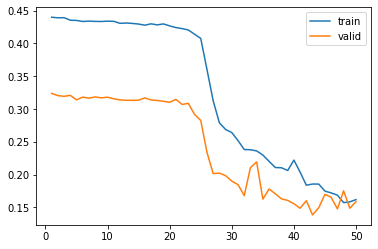

In [112]:
# Preformance de Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

## Resultados

In [113]:
y_hat_train = model.predict(X_train, verbose=0)
y_hat_test = model.predict(X_test, verbose=0)

In [114]:
print("y_hat_train:", y_hat_train.shape)
print("y_hat_test:", y_hat_test.shape)

y_hat_train: (2393, 1)
y_hat_test: (599, 1)


In [115]:
arr_tokens = np.array(tokens).reshape(-1,1)
arr_time = np.array(time).reshape(-1,1)

print(arr_tokens.shape)
print(arr_time.shape)

(3001, 1)
(3001, 1)


In [116]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(arr_tokens)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[train_len-1:len(y_hat_train)+train_len-1,:] = y_hat_train

# # predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(arr_tokens)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_hat_train)+(train_len)-1:len(arr_tokens)-1, :] = y_hat_test

print(trainPredictPlot.shape)
print(testPredictPlot.shape)

(3001, 1)
(3001, 1)


In [117]:
y_hat_train[0]

array([0.11447963], dtype=float32)

In [118]:
len(y_hat_train)+(train_len)

2402

In [119]:
import plotly.graph_objs as go

import plotly.io as pio
pio.renderers.default = "colab"


def plot_predictions(y, time, y_pred_train, y_pred_test):
    data = []
    
    value = go.Scatter(
        x=time,
        y=y,
        mode="lines",
        name="Ensayo",
        marker=dict(),
        text=time,
        line=dict(color="rgba(0, 0, 250, 0.6)"),
    )
    data.append(value)

    trainPredic = go.Scatter(
        x=time,
        y=y_pred_train,
        mode="lines",
        line=dict(color="orange"),
        name='Predicción set train',
        marker=dict(),
        text=time,
        opacity=0.8,
    )
    data.append(trainPredic)
    
    testPredictions = go.Scatter(
        x=time,
        y=y_pred_test,
        mode="lines",
        line=dict(color="rgba(0, 250, 0, 0.6)"),
        name='Predicción set test',
        marker=dict(),
        text=time,
        opacity=0.8,
    )
    data.append(testPredictions)
    
    layout = dict(
        title='Comparativa de resultados para 176s',
        xaxis=dict(title="tiempo de muestreo (s)", ticklen=5, zeroline=False),
        yaxis=dict(title="desplazamiento ($\mu$m)", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    pio.show(fig)
    
    
# Set notebook mode to work in offline
# pyo.init_notebook_mode()
plot_predictions(tokens, time, trainPredictPlot[:,0], testPredictPlot[:,0])


## Comparativa espectral

In [120]:
y.shape

(2992,)

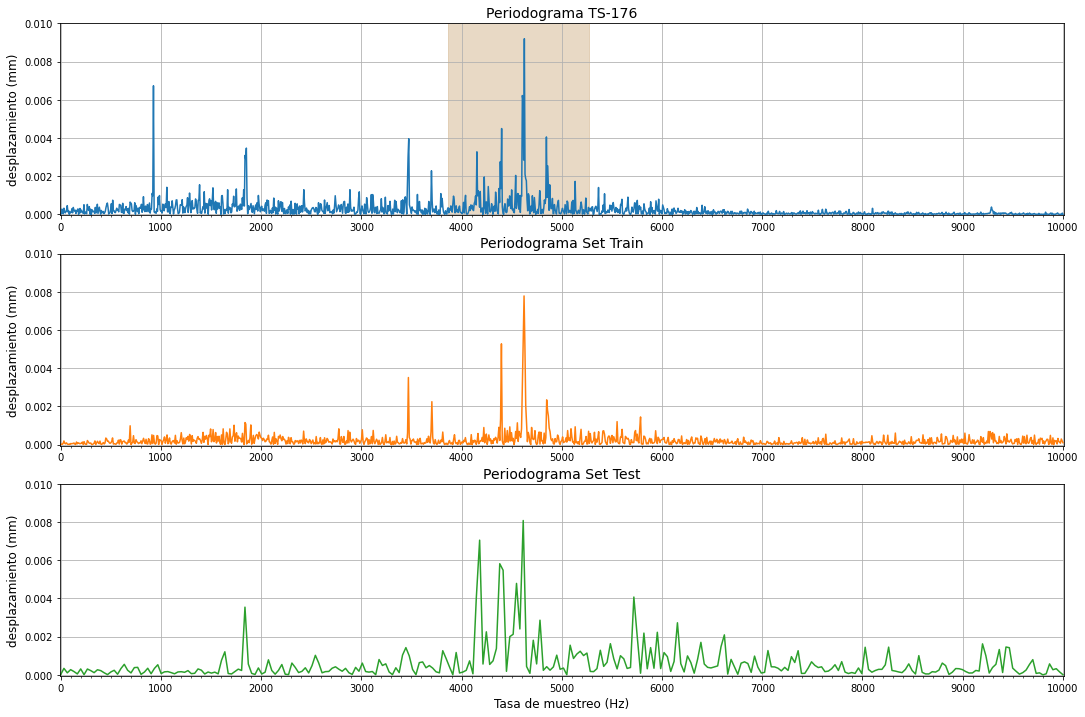

In [121]:
fig = plt.figure(figsize=(18, 12))

#------------------
fr_176, A_176 = signal.periodogram(tokens,len(tokens))
arr_sr = np.linspace(0, 10000, len(fr_176), dtype='float32')
ax1 = plt.subplot(311)
ax1.plot(arr_sr, A_176, 'C0')
ax1.set_xlim(arr_sr[0]-10, arr_sr[-1]+10)
ax1.set_ylim(-0.00005, 0.01)
ax1.grid()
ax1.fill_betweenx([-0.00005, 0.01],arr_sr[580], arr_sr[790], color ='tan', alpha = 0.5)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1000))
# ax1.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax1.set_ylabel('desplazamiento (mm)', fontsize=12)
ax1.set_title(f'Periodograma TS-176', fontsize=14)

#------------------
fr_hat_train, A_hat_train = signal.periodogram(y_hat_train[:,0],len(y_hat_train))
arr_sr_hat_train = np.linspace(0, 10000, len(fr_hat_train), dtype='float32')
ax2 = plt.subplot(312)
ax2.plot(arr_sr_hat_train, A_hat_train, 'C1')
ax2.set_xlim(arr_sr_hat_train[0]-10, arr_sr_hat_train[-1]+10)
ax2.set_ylim(-0.00005, 0.01)
ax2.grid()
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1000))
# ax2.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax2.set_ylabel('desplazamiento (mm)', fontsize=12)
ax2.set_title(f'Periodograma Set Train', fontsize=14)

#-------------------
fr_hat_test, A_hat_test = signal.periodogram(y_hat_test[:,0],len(y_hat_test))
arr_sr_hat_test = np.linspace(0, 10000, len(fr_hat_test), dtype='float32')
ax3 = plt.subplot(313)
ax3.plot(arr_sr_hat_test, A_hat_test, 'C2')
ax3.set_xlim(arr_sr_hat_test[0]-10, arr_sr_hat_test[-1]+10)
ax3.set_ylim(-0.00005, 0.01)
ax3.grid()
ax3.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax3.set_xlabel('Tasa de muestreo (Hz)', fontsize=12)
ax3.set_ylabel('desplazamiento (mm)', fontsize=12)
ax3.set_title(f'Periodograma Set Test', fontsize=14)

plt.show()